# NLP starter
github: https://github.com/JulianZhan/nlp_starter
kaggle: https://www.kaggle.com/competitions/nlp-getting-started/overview

## Introduction
In this notebook, the goal is to classify tweets as disaster-related or not. This project aims to explore different deep learning models arch to solve this classification problem.

### Data Description
The dataset contains tweets with labels indicating whether they are about real disasters or not. The data includes columns like `id`, `keyword`, `location`, `text`, and `target`. The `target` column is the label, where 1 indicates a disaster-related tweet and 0 indicates a non-disaster tweet.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

2024-05-19 13:13:24.596074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 13:13:24.596230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 13:13:24.789316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


## Data Visualization
Visualize the distribution of the target variable and the length of the tweets.

([<matplotlib.patches.Wedge at 0x7ec35cc15f00>,
 [Text(-1.0732513534192263, -0.24110481617711227, 'Not Disaster'),
  Text(1.0732513534192263, 0.2411048161771121, 'Disaster')],
 [Text(-0.5854098291377597, -0.1315117179147885, '57.0%'),
  Text(0.5854098291377597, 0.1315117179147884, '43.0%')])

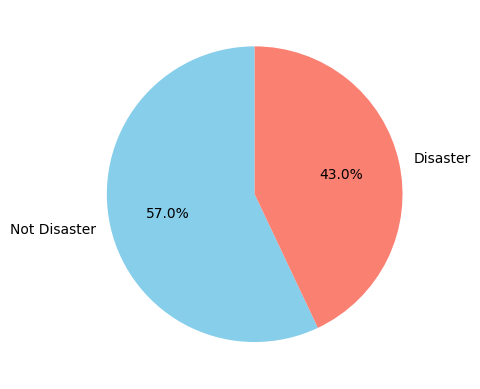

In [4]:
# Distribution of target variable
plt.pie(train_df['target'].value_counts(), labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


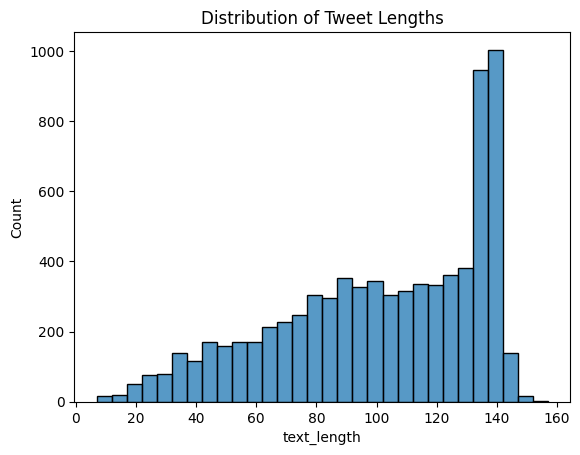

In [5]:
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(train_df['text_length'], bins=30)
plt.title('Distribution of Tweet Lengths')
plt.show()

In [6]:
print(train_df.isnull().sum())

id                0
keyword          61
location       2533
text              0
target            0
text_length       0
dtype: int64


## Data Preprocessing
1. Fill missing values with empty strings.
2. Combine text, keyword, and location into a single feature.
3. Tokenize the combined text and remove stop words.
4. Pad the sequences to a fixed length.

In [7]:
# Fill missing values with empty strings
train_df['keyword'].fillna('', inplace=True)
train_df['location'].fillna('', inplace=True)
test_df['keyword'].fillna('', inplace=True)
test_df['location'].fillna('', inplace=True)

/tmp/ipykernel_33/1251444129.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('', inplace=True)
/tmp/ipykernel_33/1251444129.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [8]:
# Combine text, keyword, and location into a single feature for training
train_df['combined_text'] = train_df['keyword'] + ' ' + train_df['location'] + ' ' + train_df['text']
test_df['combined_text'] = test_df['keyword'] + ' ' + test_df['location'] + ' ' + test_df['text']

In [9]:
# Tokenize and remove stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

train_df['processed_text'] = train_df['combined_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['combined_text'].apply(preprocess_text)

In [10]:
# Tokenize the text
tokenizer = Tokenizer(num_words=3000, lower=True)
tokenizer.fit_on_texts(train_df['processed_text'].values)
train_sequences = tokenizer.texts_to_sequences(train_df['processed_text'].values)
test_sequences = tokenizer.texts_to_sequences(test_df['processed_text'].values)

# Pad the sequences
max_seq_len = 160
X_train = pad_sequences(train_sequences, maxlen=max_seq_len)
X_test = pad_sequences(test_sequences, maxlen=max_seq_len)
y_train = train_df['target'].values

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## Model Building
We build three different models for this classification task: 
 1. LSTM model
2. GRU model
3. Bidirectional LSTM model
Each model uses an embedding layer followed by a dense output layer.

In [12]:
def build_lstm_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gru_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(30, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_bidirectional_lstm_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(30, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=64):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return val_loss, val_accuracy

## Model Training
Start training the LSTM, GRU, and Bidirectional LSTM models. And evaluate the models using the validation set.

In [14]:
input_dim = 3000
output_dim = 128
input_length = max_seq_len

lstm_model = build_lstm_model(input_dim, output_dim, input_length)
gru_model = build_gru_model(input_dim, output_dim, input_length)
bidirectional_lstm_model = build_bidirectional_lstm_model(input_dim, output_dim, input_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


LSTM Model:
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6129 - loss: 0.6456 - val_accuracy: 0.7958 - val_loss: 0.4641
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8298 - loss: 0.3968 - val_accuracy: 0.7997 - val_loss: 0.4380
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8651 - loss: 0.3321 - val_accuracy: 0.8050 - val_loss: 0.4674
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8835 - loss: 0.2993 - val_accuracy: 0.7965 - val_loss: 0.4898
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8926 - loss: 0.2723 - val_accuracy: 0.7945 - val_loss: 0.5244
Epoch 5: early stopping


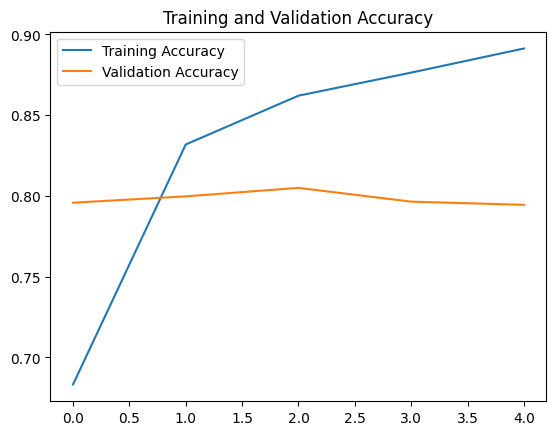

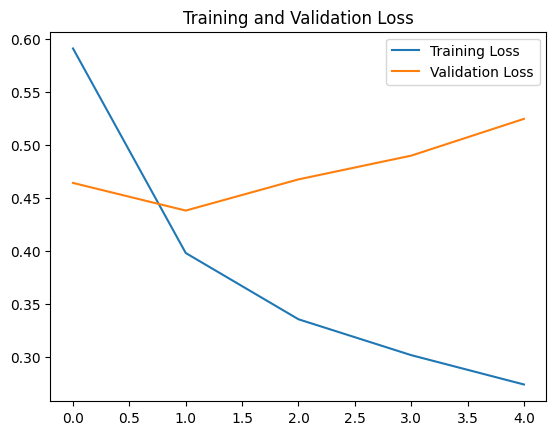

Validation Loss: 0.5244, Validation Accuracy: 0.7945


In [15]:
print("LSTM Model:")
lstm_loss, lstm_accuracy = train_and_evaluate_model(lstm_model, X_train, y_train, X_val, y_val)

GRU Model:
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.6212 - loss: 2933.4192 - val_accuracy: 0.7505 - val_loss: 0.5443
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.8126 - loss: 5.7129 - val_accuracy: 0.7827 - val_loss: 0.4833
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8409 - loss: 867199.5000 - val_accuracy: 0.7768 - val_loss: 0.4961
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8546 - loss: 0.3877 - val_accuracy: 0.7820 - val_loss: 0.4899
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8548 - loss: 11.8565 - val_accuracy: 0.7807 - val_loss: 0.4874
Epoch 5: early stopping


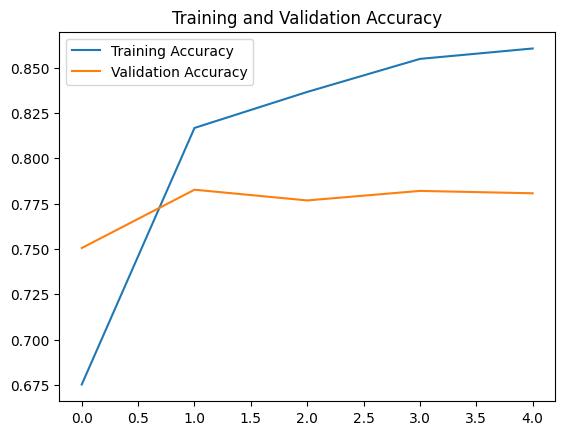

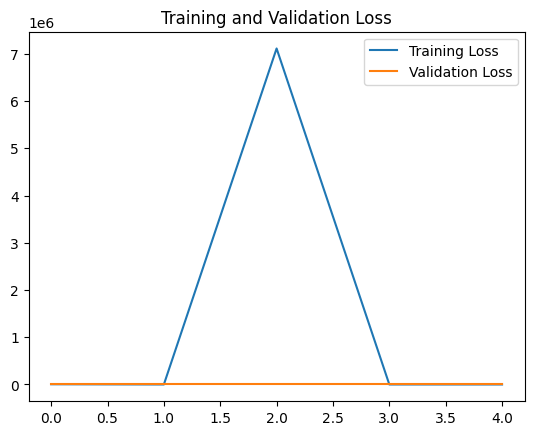

Validation Loss: 0.4874, Validation Accuracy: 0.7807


In [16]:
print("GRU Model:")
gru_loss, gru_accuracy = train_and_evaluate_model(gru_model, X_train, y_train, X_val, y_val)

Bidirectional LSTM Model:
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5974 - loss: 0.6564 - val_accuracy: 0.7912 - val_loss: 0.4770
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8219 - loss: 0.4167 - val_accuracy: 0.8056 - val_loss: 0.4454
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8726 - loss: 0.3314 - val_accuracy: 0.8011 - val_loss: 0.4711
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8959 - loss: 0.2855 - val_accuracy: 0.7991 - val_loss: 0.4858
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9055 - loss: 0.2606 - val_accuracy: 0.7912 - val_loss: 0.5229
Epoch 5: early stopping


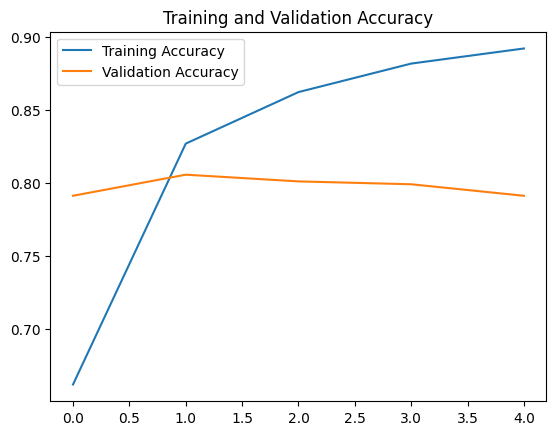

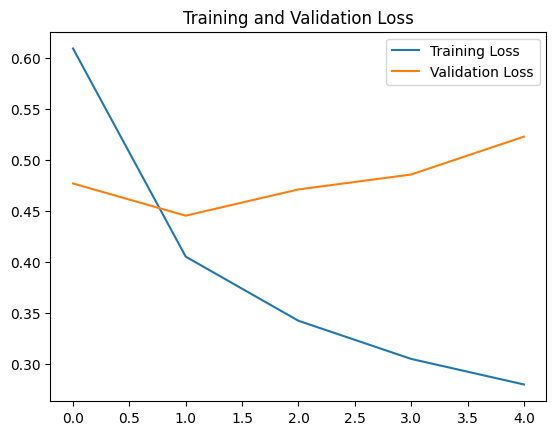

Validation Loss: 0.5229, Validation Accuracy: 0.7912


In [17]:
print("Bidirectional LSTM Model:")
bidirectional_lstm_loss, bidirectional_lstm_accuracy = train_and_evaluate_model(bidirectional_lstm_model, X_train, y_train, X_val, y_val)

## Model Evaluation
Evaluate the models using the validation set and choose the best model for making predictions on the test set.
For this classification task, the LSTM model has the highest validation accuracy.

In [18]:
print(f'LSTM Validation Accuracy: {lstm_accuracy:.4f}')
print(f'GRU Validation Accuracy: {gru_accuracy:.4f}')
print(f'Bidirectional LSTM Validation Accuracy: {bidirectional_lstm_accuracy:.4f}')

LSTM Validation Accuracy: 0.7945
GRU Validation Accuracy: 0.7807
Bidirectional LSTM Validation Accuracy: 0.7912


In [20]:
predictions = lstm_model.predict(X_test, batch_size=64, verbose=1)
predictions = (predictions > 0.5).astype(int)

submission_df['target'] = predictions
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
lstm_model.save('lstm_model.h5')

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


## Conclusion
In this notebook, we explored different deep learning models for classifying tweets as disaster-related or not. We built LSTM, GRU, and Bidirectional LSTM models and trained them on the training data. The LSTM model achieved the highest validation accuracy and was used to make predictions on the test set.